# Plotting fire frequencies at different spatiotemporal scales

Authors: Jatan Buch (v1, 220207) || (v2, 220216)

## Packages

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
#from time import clock
from datetime import date, datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm
from copy import deepcopy

#Import and write files
import csv
import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader

#self-libraries
from fire_utils import *
from ml_utils import *

#Helper functions
from math import factorial
from scipy import stats
from scipy.special import gamma
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError
from tensorflow.python import ops
from tensorflow.python import debug as tf_debug

#Plot modules
import matplotlib.pyplot as plt
%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

#Stats modules
from scipy import stats
from scipy.stats import norm, pareto, genpareto
import statsmodels.api as sm
from scipy import stats, interpolate
from scipy.optimize import minimize

# Data processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, SplineTransformer
from sklearn.model_selection import train_test_split
import joblib
from sklearn.pipeline import make_pipeline

#modules for Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression

#modules for Neural Network
import tensorflow as tf
import tensorflow_probability as tfp
tfd= tfp.distributions
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
#from tensorflow.keras import layers
#from tensorflow.python.ops.parallel_for.gradients import jacobian

In [2]:
from plot_params import params
import matplotlib.pylab as pylab

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
fire_file= "../data/burnarea_12km.nc"

## MDN grid scale frequency 

### Model loading

In [5]:
run_id= '03_01_22'
hp_df= pd.read_hdf('../sav_files/grid_freq_runs_%s'%run_id + '/grid_freq_hyperparams.h5')

In [6]:
hp_df

,Iteration,Batch size,Fire fraction,Epochs,Val Accuracy/Recall
0,1,8192,0.3,82,0.611756
1,2,8192,0.3,118,0.596748
2,3,8192,0.3,130,0.652295
3,4,8192,0.3,77,0.567084
4,5,8192,0.3,110,0.634249
5,6,8192,0.3,108,0.508326
6,7,8192,0.3,109,0.589009
7,8,8192,0.3,82,0.487335
8,9,8192,0.3,94,0.622672
9,10,8192,0.3,100,0.648475


In [4]:
mdn_freq_df= pd.read_hdf('../sav_files/mdn_mon_fire_freq_02_27_22_it_2_8192_0.3.h5')
mdn_freq_groups= mdn_freq_df.groupby('reg_indx')
mdn_ds_freq_df= pd.read_hdf('../sav_files/mdn_ds_mon_fire_freq_03_01_22.h5')
mdn_ds_freq_groups= mdn_ds_freq_df.groupby('reg_indx')
mdn_alt_ds_freq_df= pd.read_hdf('../sav_files/mdn_ds_mon_fire_freq_03_02_22.h5') # leaves training data ut starting from month 264 instead of 372
mdn_alt_ds_freq_groups= mdn_ds_freq_df.groupby('reg_indx')
dnn_freq_df= pd.read_hdf('../sav_files/dnn_mon_fire_freq_03_01_22_it_12_8192_0.3.h5')
dnn_freq_groups= dnn_freq_df.groupby('reg_indx')
dnn_ds_freq_df= pd.read_hdf('../sav_files/dnn_ds_mon_fire_freq_02_25_22.h5')
dnn_ds_freq_groups= dnn_ds_freq_df.groupby('reg_indx')
mdn_loro_freq_df= pd.read_hdf('../sav_files/mdn_ds_mon_fire_freq_03_03_22.h5') # loro; currently only has region 7

In [5]:
mdn_ds_mon_freq_df, mdn_ds_ann_freq_df= calib_freq_predict(ml_freq_df= mdn_alt_ds_freq_df, n_regs= 18, tot_months= tot_months, test_start= 264, test_tot= 60, ml_model= 'mdn') #debug= True, regindx= 7, arg_arr= ['linear', 'mean', 'mean'])
mdn_ds_mon_freq_groups= mdn_ds_mon_freq_df.groupby('reg_indx')
mdn_ds_ann_freq_groups= mdn_ds_ann_freq_df.groupby('reg_indx')

100%|██████████| 18/18 [00:02<00:00,  6.27it/s]


### WUS frequencies

In [3]:
final_month= 432
tot_months= final_month #- start_month
n_regions= 18

#month_arr= np.linspace(start_month, final_month - 1, tot_months, dtype= np.int64)
month_arr= np.linspace(0, final_month - 1, tot_months, dtype= np.int64)
year_arr=  np.arange(1984, 2021, 4) #np.asarray([2006, 2009, 2012, 2015, 2018, 2021]) #np.asarray([2015, 2016, 2017, 2018, 2019, 2020])
yr_arr= np.arange(0, tot_months + 1, 12)

In [13]:
tot_mon_obs_freq_arr= []
tot_mon_pred_freq_arr= []
tot_mon_pred_high_2sig_arr= []
tot_mon_pred_low_2sig_arr= []
tot_ann_obs_freq_arr= []
tot_ann_pred_freq_arr= []
tot_ann_pred_high_2sig_arr= []
tot_ann_pred_low_2sig_arr= []

for r in tqdm(range(18)):
    tot_mon_obs_freq_arr.append(mdn_ds_mon_freq_groups.get_group(r+1)['obs_freq'].to_numpy())
    tot_mon_pred_freq_arr.append(mdn_ds_mon_freq_groups.get_group(r+1)['pred_mean_freq'].to_numpy())
    tot_mon_pred_high_2sig_arr.append(mdn_ds_mon_freq_groups.get_group(r+1)['pred_high_2sig'].to_numpy())
    tot_mon_pred_low_2sig_arr.append(mdn_ds_mon_freq_groups.get_group(r+1)['pred_low_2sig'].to_numpy())
    tot_ann_obs_freq_arr.append(mdn_ds_ann_freq_groups.get_group(r+1)['obs_freq'].to_numpy())
    tot_ann_pred_freq_arr.append(mdn_ds_ann_freq_groups.get_group(r+1)['pred_mean_freq'].to_numpy())
    tot_ann_pred_high_2sig_arr.append(mdn_ds_ann_freq_groups.get_group(r+1)['pred_high_2sig'].to_numpy())
    tot_ann_pred_low_2sig_arr.append(mdn_ds_ann_freq_groups.get_group(r+1)['pred_low_2sig'].to_numpy())

100%|██████████| 18/18 [00:00<00:00, 116.96it/s]


In [14]:
tot_mon_freq_r= stats.pearsonr(np.sum(tot_mon_obs_freq_arr, axis= 0), np.sum(tot_mon_pred_freq_arr, axis= 0))[0]
tot_ann_freq_r= stats.pearsonr(np.sum(tot_ann_obs_freq_arr, axis= 0), np.sum(tot_ann_pred_freq_arr, axis= 0))[0]

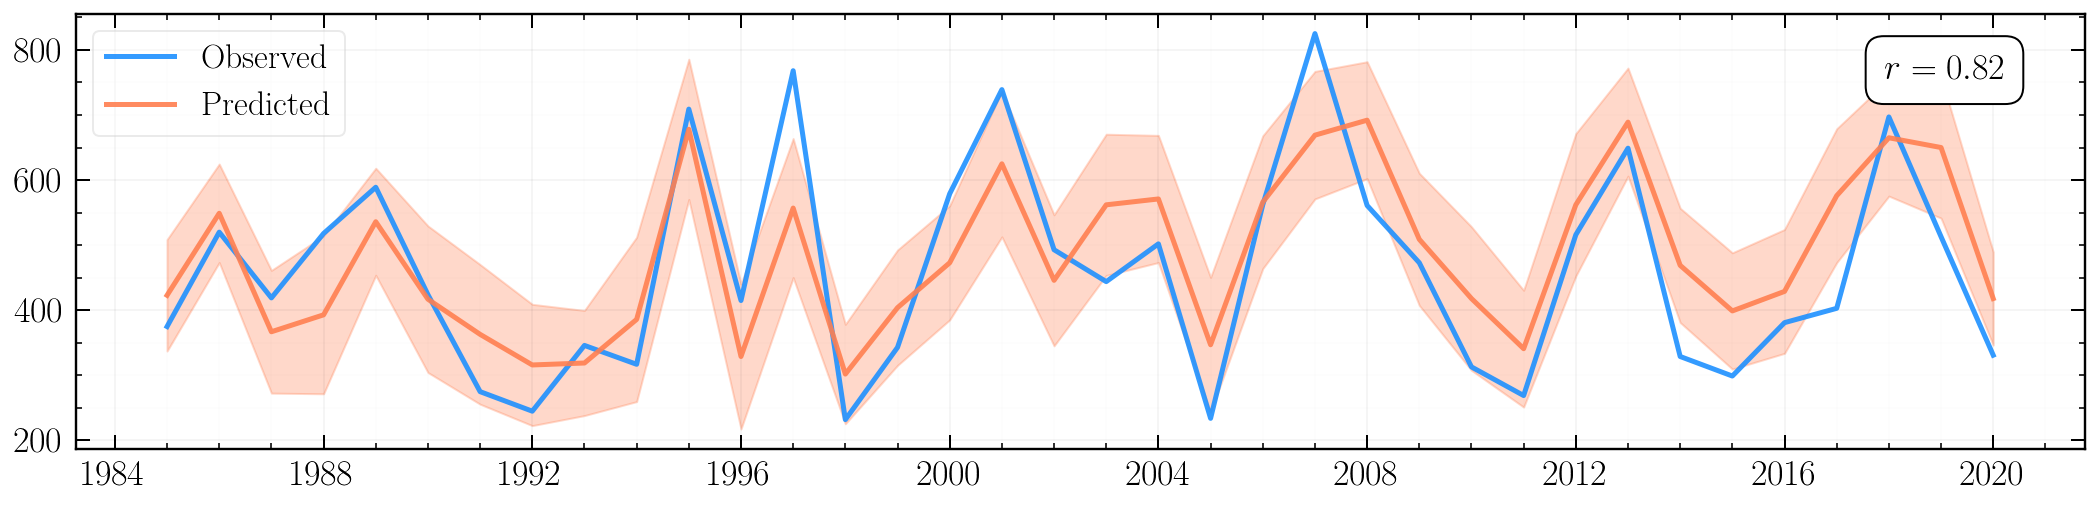

In [21]:
fig, ax= plt.subplots(1, 1, figsize=(18, 4))

plt.plot(yr_arr[1:], np.sum(tot_ann_obs_freq_arr, axis= 0), color= 'dodgerblue', label= 'Observed');
plt.plot(yr_arr[1:], np.sum(tot_ann_pred_freq_arr, axis= 0), color= 'coral', label= 'Predicted');
plt.fill_between(yr_arr[1:], np.sum(tot_ann_pred_high_2sig_arr, axis= 0), np.sum(tot_ann_pred_low_2sig_arr, axis= 0), color= 'coral', alpha= 0.3)
plt.legend(loc='upper left', frameon= True);
#plt.title(r'${\rm Western \ United \ States}$', fontsize= 18);
ax.set_xticks((year_arr - 1984)*12);
ax.set_xticklabels(year_arr)
ax.text(0.9, 0.85, r'$r = %.2f$'%tot_ann_freq_r, fontsize= 18, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax.transAxes)

fig.subplots_adjust(hspace= 0.8)
#fig.minorticks_on()
ax.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
ax.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_ann_fire_freq_all.pdf', bbox_inches='tight');

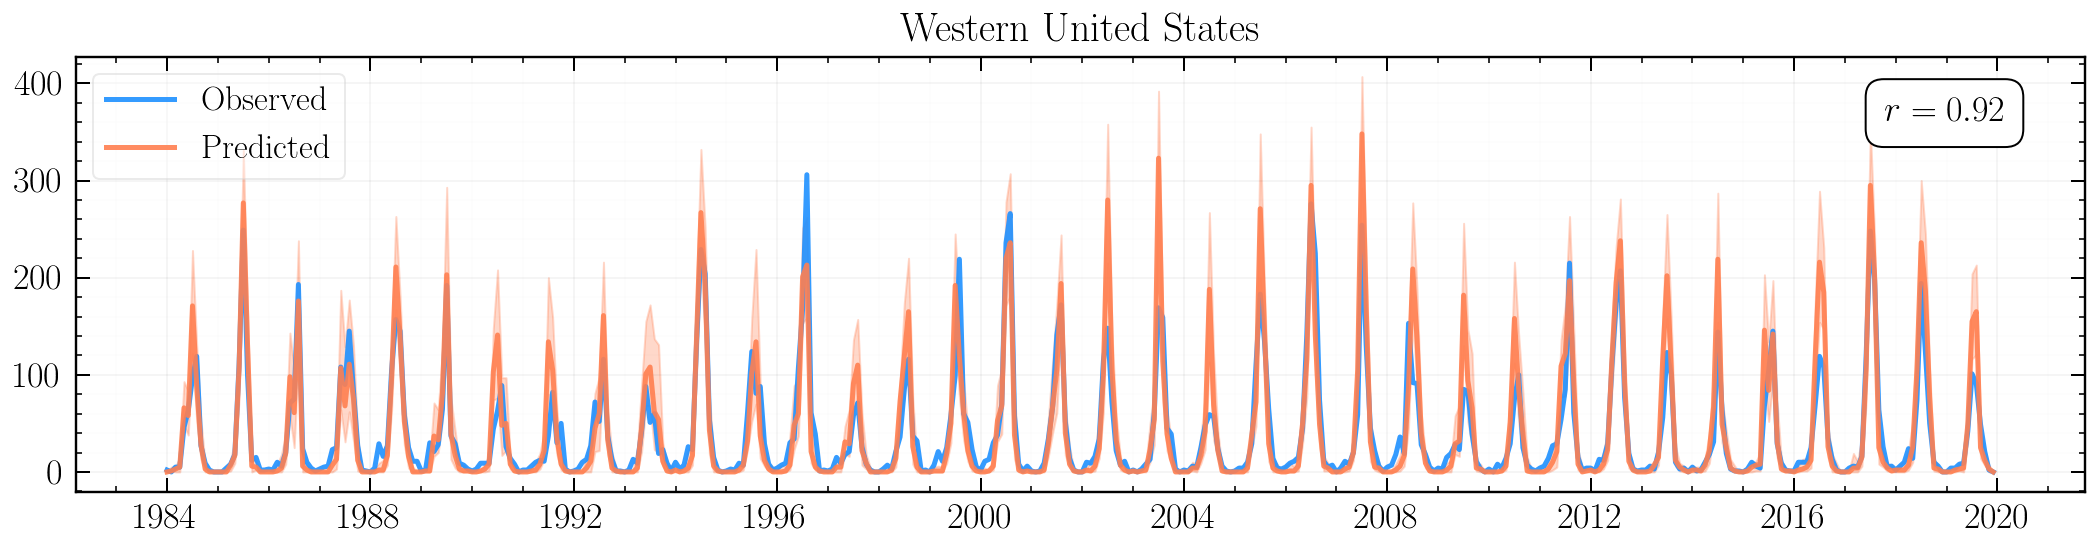

In [23]:
fig, ax= plt.subplots(1, 1, figsize=(18, 4))

plt.plot(month_arr, np.sum(tot_mon_obs_freq_arr, axis= 0), color= 'dodgerblue', label= 'Observed');
plt.plot(month_arr, np.sum(tot_mon_pred_freq_arr, axis= 0), color= 'coral', label= 'Predicted');
plt.fill_between(month_arr, np.sum(tot_mon_pred_high_2sig_arr, axis= 0), np.sum(tot_mon_pred_low_2sig_arr, axis= 0), color= 'coral', alpha= 0.3)
plt.legend(loc='upper left', frameon= True);
plt.title(r'${\rm Western \ United \ States}$', fontsize= 20);
ax.set_xticks((year_arr - 1984)*12);
ax.set_xticklabels(year_arr)
ax.text(0.9, 0.85, r'$r = %.2f$'%tot_mon_freq_r, fontsize= 18, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax.transAxes)

fig.subplots_adjust(hspace= 0.8)
#fig.minorticks_on()
ax.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
ax.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_mon_fire_freq_all.pdf', bbox_inches='tight');

### Regional frequencies

In [24]:
startmon= 264
totmonths= final_month - startmon
month_arr= np.linspace(startmon, final_month - 1, totmonths, dtype= np.int64)
year_arr= np.asarray([2006, 2009, 2012, 2015, 2018, 2021]) #np.asarray([2015, 2016, 2017, 2018, 2019, 2020])
yr_arr= np.arange(0, tot_months + 1, 12) 

reg_name= {1: "Sierra Nevada", 2: "North Coast", 3: "Central Coast", 4: "South Coast", 5: "Pacific NW", 6: "Columbia Plateau", 7:"Northern Rockies", \
          8: "Middle Rockies", 9: "Southern Rockies", 10: "AM Semidesert", 11: "AZ/NM Mts.", 12: "IM Semidesert", 13: "IM Desert", 14: "Northern Great Plains", \
          15: "High Plains", 16: "CO Plateau", 17: "SW Tablelands", 18: "CH Desert"}
ind_grid_1= [[1, 6], [7, 8]]
ind_grid_2= [[11, 12], [13, 14]]

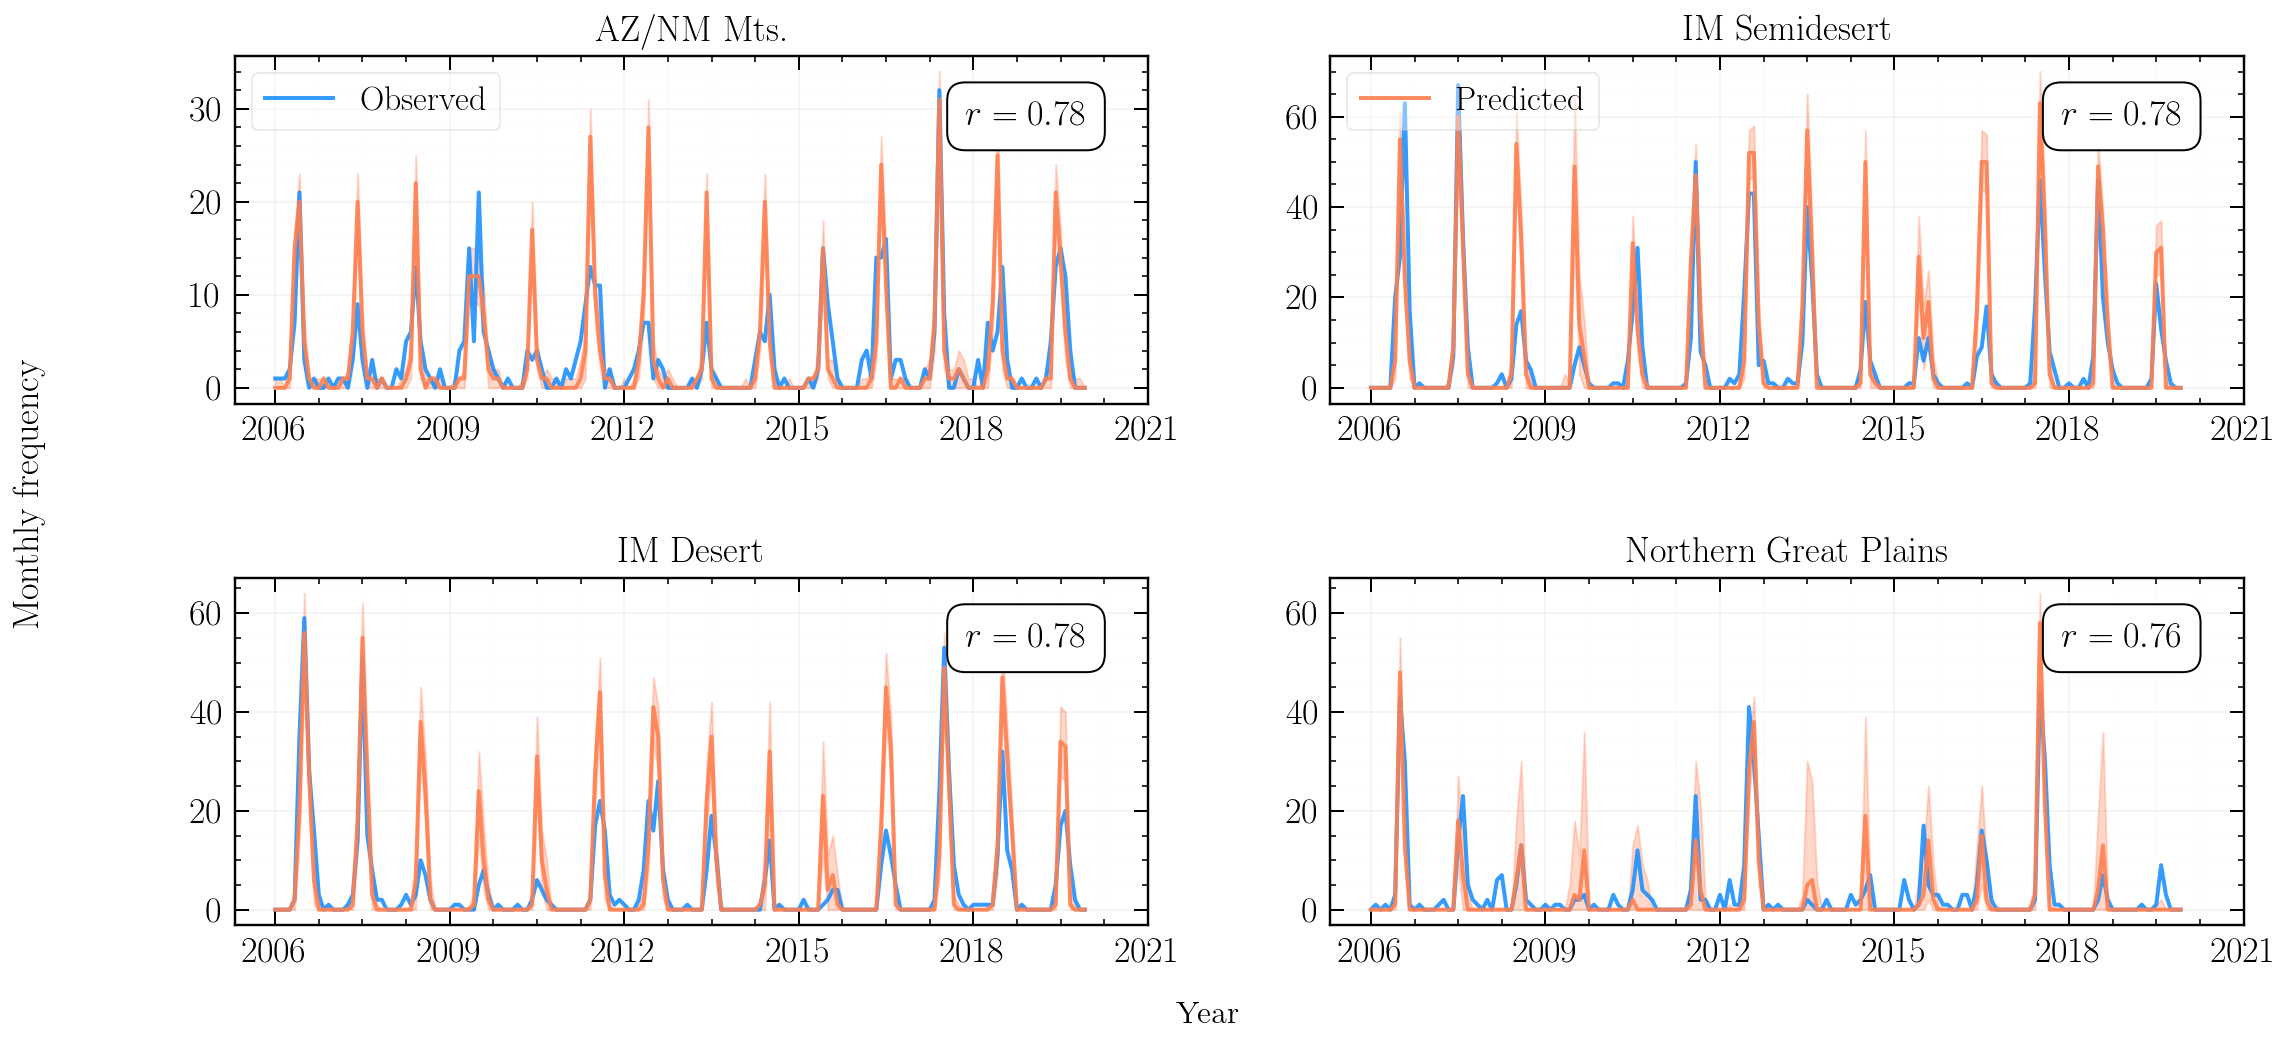

In [39]:
fig, ax= plt.subplots(2, 2, figsize=(18, 8))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly frequency', va='center', rotation='vertical', fontsize= 18);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

for i in range(2):
    for j in range(2):
        regindx= ind_grid_2[i][j]
        reg_mon_r_calib= stats.pearsonr(mdn_ds_mon_freq_groups.get_group(regindx)['obs_freq'], mdn_ds_mon_freq_groups.get_group(regindx)['pred_mean_freq'])[0]
        
        if i+j == 0:
            ax[i, j].plot(month_arr, mdn_ds_mon_freq_groups.get_group(regindx)['obs_freq'][startmon:], color= 'dodgerblue', lw= 2, label= 'Observed');
            ax[i, j].legend(loc='upper left', frameon= True);
        else:
            ax[i, j].plot(month_arr, mdn_ds_mon_freq_groups.get_group(regindx)['obs_freq'][startmon:], color= 'dodgerblue', lw= 2);
        if (i==0)&(j==1):
            ax[i, j].plot(month_arr, mdn_ds_mon_freq_groups.get_group(regindx)['pred_mean_freq'][startmon:], color= 'coral', lw= 2, label= 'Predicted');
            ax[i, j].legend(loc='upper left', frameon= True);
        else:
            ax[i, j].plot(month_arr, mdn_ds_mon_freq_groups.get_group(regindx)['pred_mean_freq'][startmon:], color= 'coral', lw= 2);
        ax[i, j].fill_between(month_arr, mdn_ds_mon_freq_groups.get_group(regindx)['pred_high_2sig'][startmon:], \
                              mdn_ds_mon_freq_groups.get_group(regindx)['pred_low_2sig'][startmon:], color= 'coral', alpha= 0.3)
        ax[i, j].set_title(reg_name[regindx], fontsize= 18);
        ax[i, j].set_xticks((year_arr - 2006)*12 + startmon);
        ax[i, j].set_xticklabels(year_arr)
        ax[i, j].text(0.8, 0.8, r'$r = %.2f$'%reg_mon_r_calib, fontsize= 18, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[i, j].transAxes)
            
        fig.subplots_adjust(hspace= 0.5)
        #fig.minorticks_on()
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_mon_fire_freq_2.pdf', bbox_inches='tight');

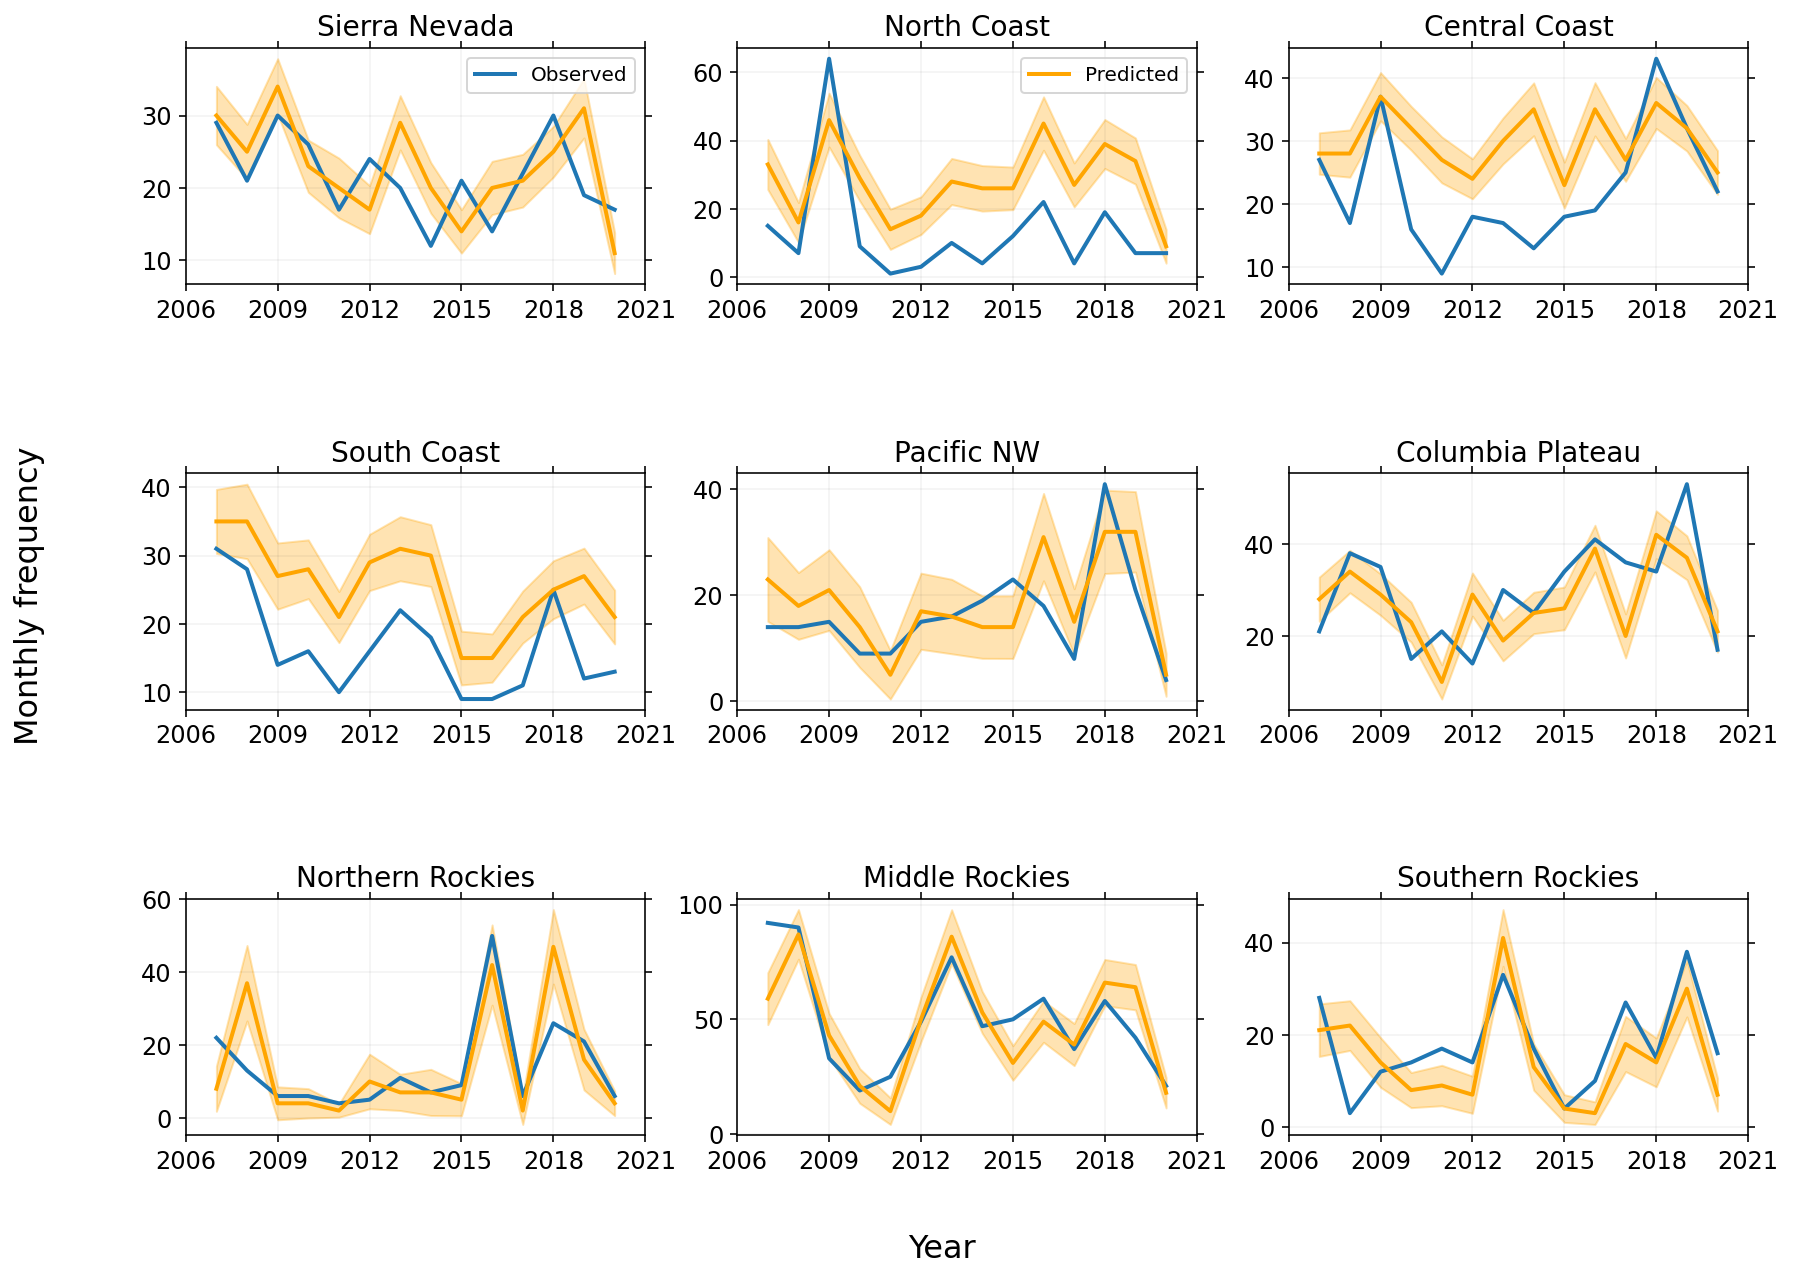

In [116]:
fig, ax= plt.subplots(3, 3, figsize=(14, 10))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly frequency', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

for i in range(3):
    for j in range(3):
        regindx= ind_grid_1[i][j]
        obs_freqs= np.array([np.sum(mdn_freq_groups.get_group(regindx)['obs_freq'][yr_arr[t]:yr_arr[t+1]]) for t in range(len(yr_arr) - 1)])
        pred_freqs= np.array([np.sum(mdn_freq_groups.get_group(regindx)['pred_mean_freq'][yr_arr[t]:yr_arr[t+1]]) for t in range(len(yr_arr) - 1)])
        pred_std= np.asarray([np.sqrt(np.sum((((mdn_freq_groups.get_group(regindx)['pred_high_2sig'] - \
                    mdn_freq_groups.get_group(regindx)['pred_low_2sig'])/4)**2)[yr_arr[t]:yr_arr[t+1]])) for t in range(len(yr_arr) - 1)]) 
        if i+j == 0:
            ax[i, j].plot(yr_arr[1:], obs_freqs, lw= 2, label= 'Observed');
            ax[i, j].legend(loc='upper right', frameon= True);
        else:
            ax[i, j].plot(yr_arr[1:], obs_freqs, lw= 2);
        if (i==0)&(j==1):
            ax[i, j].plot(yr_arr[1:], pred_freqs, color= 'orange', lw= 2, label= 'Predicted');
            ax[i, j].legend(loc='upper right', frameon= True);
        else:
            ax[i, j].plot(yr_arr[1:], pred_freqs, color= 'orange', lw= 2);
        ax[i, j].fill_between(yr_arr[1:], pred_freqs + 2*pred_std, pred_freqs - 2*pred_std, color= 'orange', alpha= 0.3)
        ax[i, j].set_title(reg_name[regindx], fontsize= 14);
        ax[i, j].set_xticks((year_arr - 2006)*12);
        ax[i, j].set_xticklabels(year_arr)
            
        fig.subplots_adjust(hspace= 0.8)
        #fig.minorticks_on()
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_fire_freq_1.pdf', bbox_inches='tight');

## Grid fire locations

In [181]:
run_id, it, bs, p_frac= ['02_27_22', 2, 8192, '0.3']
reg_pred_freq= bailey_ecoprovince_mask('../sav_files/pred_freq_%s'%run_id + '_%s'%bs + '_pfrac_%s'%str(p_frac) + '_iter_run_%d.nc'%it, region= "northern_rockies")
reg_obs_freq= bailey_ecoprovince_mask('../sav_files/obs_freq.nc', region= "northern_rockies")
lat_long_fire_grid= coord_transform(reg_pred_freq['X'][:].data, reg_pred_freq['Y'][:].data, input_crs= 'EPSG:5070')

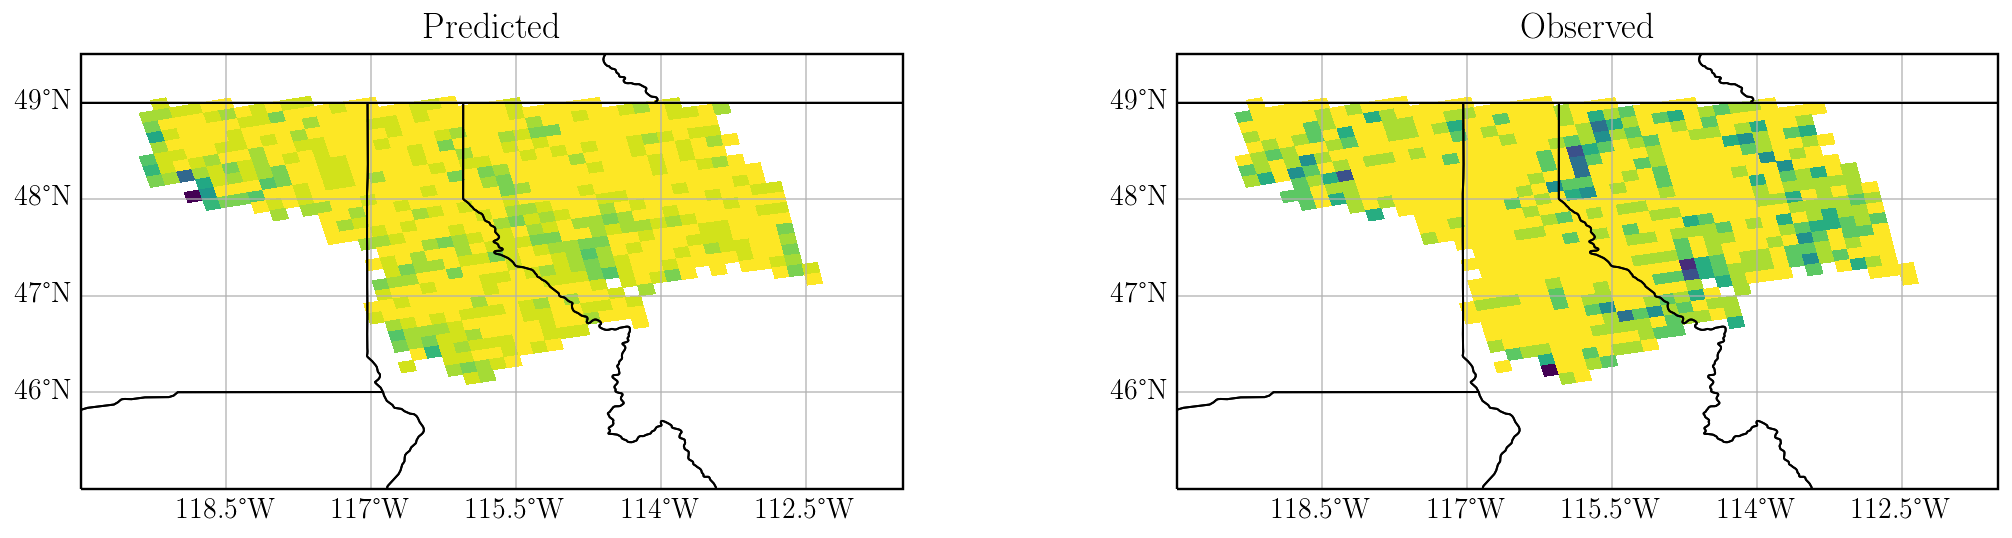

In [218]:
extent = [-120, -111.5, 45, 49.5] #[-120.5, -112.5, 42, 48.5] #[-124.5, -115.5, 32, 42.5] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

fig= plt.figure(figsize=(18, 4)) 

ax0= plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax0.set_extent(extent);

ax0.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax0.add_feature(cfeature.STATES, edgecolor='black', zorder= 10);

gl= ax0.gridlines(draw_labels=True, alpha= 0.8);
gl.top_labels = False;
gl.right_labels = False;
gl.xlabel_style = {'size': 14};
gl.ylabel_style = {'size': 14};

CS = ax0.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], (1/7.5)*np.sum(reg_pred_freq.values, axis= 0)/np.max(reg_pred_freq).values, cmap=plt.cm.viridis_r)
#cbar= fig.colorbar(CS, ax= ax0, shrink= 0.6)
ax0.set_title(r'$\rm{Predicted}$', fontsize= 18);

ax1= plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax1.set_extent(extent);

ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax1.add_feature(cfeature.STATES, edgecolor='black', zorder= 10);

gl1= ax1.gridlines(draw_labels=True, alpha= 0.8);
gl1.top_labels = False;
gl1.right_labels = False;
gl1.xlabel_style = {'size': 14};
gl1.ylabel_style = {'size': 14};

CS1 = ax1.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], (1/4)*np.sum(reg_obs_freq.values, axis= 0)/np.max(reg_pred_freq).values, cmap=plt.cm.viridis_r) #
#cbar1= fig.colorbar(CS1)
ax1.set_title(r'$\rm{Observed}$', fontsize= 18);
#plt.savefig('../plots/grid_freq_loc_nrockies.jpg', bbox_inches='tight');

## MDN grid scale fire size

### Model loading

In [88]:
size_id= '03_13_22'
freq_id= '02_27_22'

reg_ml_gpd_size_df= pd.read_hdf('../sav_files/gpd_mon_fire_size_%s'%size_id + '_ml_freq_run_%s'%freq_id + '_df.h5')
reg_ml_lognorm_size_df= pd.read_hdf('../sav_files/lognorm_mon_fire_size_%s'%size_id + '_ml_freq_run_%s'%freq_id + '_df.h5')
reg_data_size_df= pd.read_hdf('../sav_files/gpd_mon_fire_size_%s'%size_id + '_data_freq_df.h5')

### WUS sizes

In [42]:
final_month= 432
tot_months= final_month #- start_month
n_regions= 18

#month_arr= np.linspace(start_month, final_month - 1, tot_months, dtype= np.int64)
month_arr= np.linspace(0, final_month - 1, tot_months, dtype= np.int64)
year_arr=  np.arange(1984, 2021, 4) #np.asarray([2006, 2009, 2012, 2015, 2018, 2021]) #np.asarray([2015, 2016, 2017, 2018, 2019, 2020])
yr_arr= np.arange(0, tot_months + 1, 12)

In [43]:
tot_mon_obs_size_arr= []
tot_mon_pred_size_arr= []
tot_mon_pred_high_1sig_arr= []
tot_mon_pred_low_1sig_arr= []
tot_ann_obs_size_arr= []
tot_ann_pred_size_arr= []
tot_ann_pred_high_1sig_arr= []
tot_ann_pred_low_1sig_arr= []

for r in tqdm(range(18)):
    tot_mon_obs_size_arr.append(mon_burned_area(fire_file, r+1).values)
    tot_mon_pred_size_arr.append(reg_data_size_df.groupby('reg_indx').get_group(r+1)['mean_size'].to_numpy())
    tot_mon_pred_high_1sig_arr.append(reg_data_size_df.groupby('reg_indx').get_group(r+1)['high_1sig_size'].to_numpy())
    tot_mon_pred_low_1sig_arr.append(reg_data_size_df.groupby('reg_indx').get_group(r+1)['low_1sig_size'].to_numpy())
    tot_ann_obs_size_arr.append(np.array([np.sum(tot_mon_obs_size_arr[r][yr_arr[i]:yr_arr[i+1]]) for i in range(len(yr_arr) - 1)]))
    tot_ann_pred_size_arr.append(np.array([np.sum(tot_mon_pred_size_arr[r][yr_arr[i]:yr_arr[i+1]]) for i in range(len(yr_arr) - 1)]))
    tot_ann_pred_high_1sig_arr.append(np.array([np.sqrt(np.sum(np.power(tot_mon_pred_high_1sig_arr[r][yr_arr[i]:yr_arr[i+1]], 2))) for i in range(len(yr_arr) - 1)]))
    tot_ann_pred_low_1sig_arr.append(np.array([np.sqrt(np.sum(np.power(tot_mon_pred_low_1sig_arr[r][yr_arr[i]:yr_arr[i+1]], 2))) for i in range(len(yr_arr) - 1)]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.86it/s]


In [44]:
tot_mon_size_r= stats.pearsonr(np.sum(tot_mon_obs_size_arr, axis= 0), np.sum(tot_mon_pred_size_arr, axis= 0))[0]
tot_ann_size_r= stats.pearsonr(np.sum(tot_ann_obs_size_arr, axis= 0), np.sum(tot_ann_pred_size_arr, axis= 0))[0]

In [63]:
metrics.r2_score(np.sum(tot_ann_obs_size_arr, axis= 0), np.sum(tot_ann_pred_size_arr, axis= 0))

0.12911188882728153

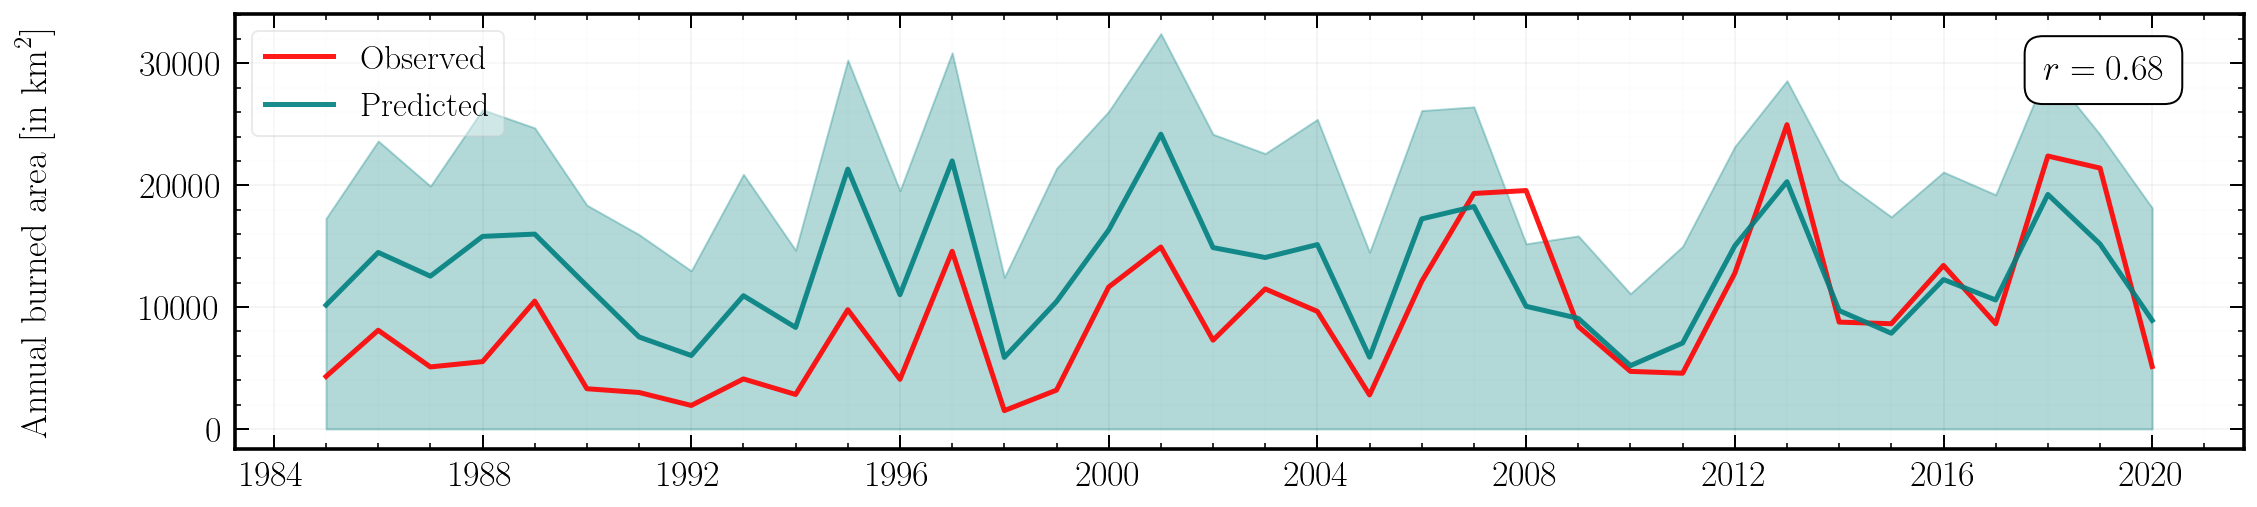

In [45]:
fig, ax= plt.subplots(1, 1, figsize=(18, 4))
fig.text(0.04, 0.5, r'Annual burned area [in ${\rm km}^2$]', va='center', rotation='vertical', fontsize= 18);

plt.plot(yr_arr[1:], np.sum(tot_ann_obs_size_arr, axis= 0), color= 'red', label= 'Observed');
plt.plot(yr_arr[1:], np.sum(tot_ann_pred_size_arr, axis= 0), color= 'teal', label= 'Predicted');
plt.fill_between(yr_arr[1:], 0.6*np.sum(tot_ann_pred_high_1sig_arr, axis= 0), 0.6*np.sum(tot_ann_pred_low_1sig_arr, axis= 0), color= 'teal', alpha= 0.3)
plt.legend(loc='upper left', frameon= True);
#plt.title(r'${\rm Western \ United \ States}$', fontsize= 18);
ax.set_xticks((year_arr - 1984)*12);
ax.set_xticklabels(year_arr);
ax.text(0.9, 0.85, r'$r = %.2f$'%tot_ann_size_r, fontsize= 18, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax.transAxes)

fig.subplots_adjust(hspace= 0.8)
#fig.minorticks_on()
ax.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
ax.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_ann_fire_size_all.pdf', bbox_inches='tight');

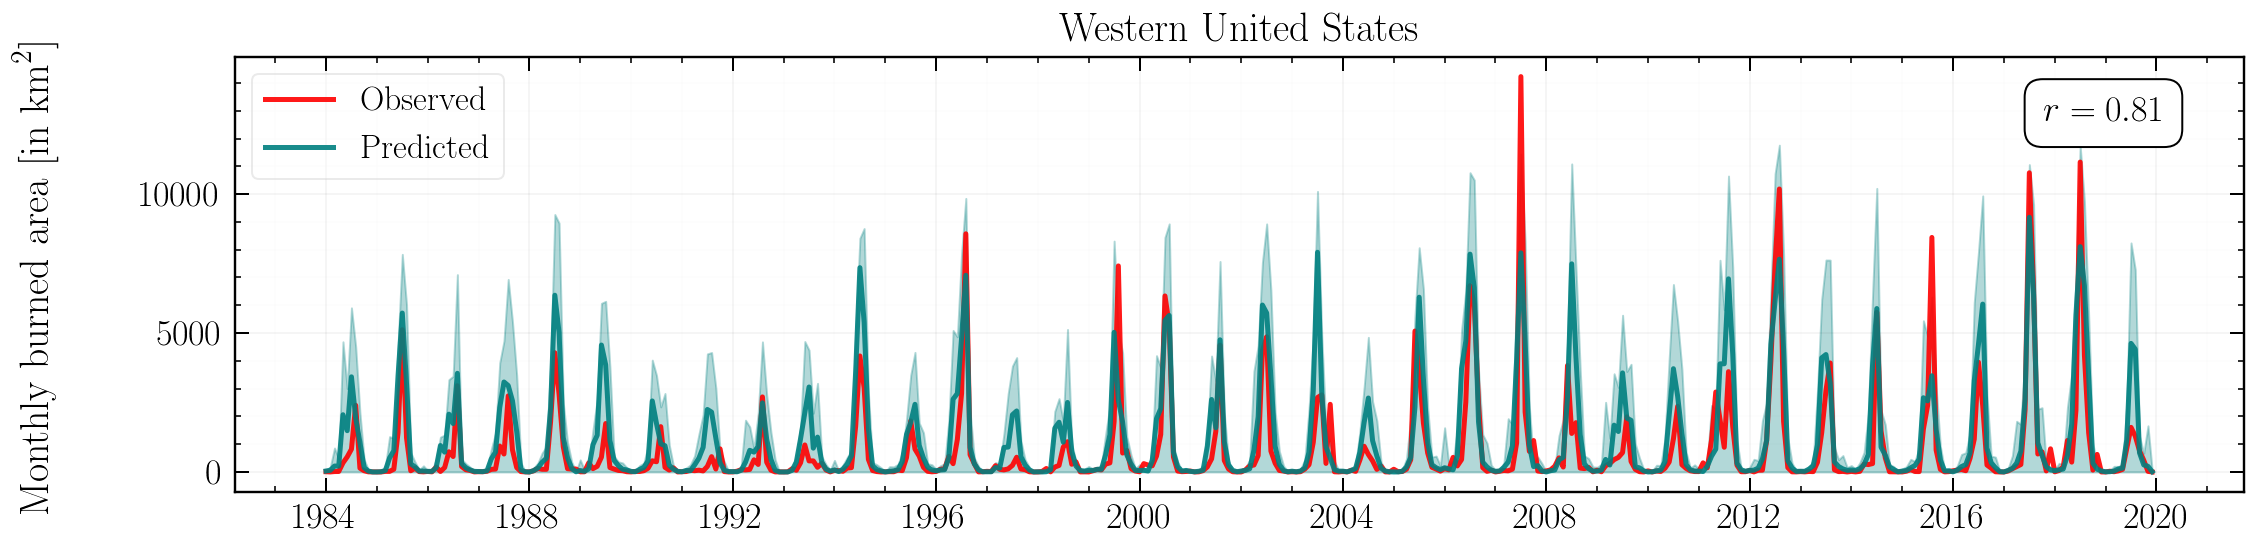

In [166]:
fig, ax= plt.subplots(1, 1, figsize=(18, 4))
fig.text(0.04, 0.5, r'Monthly burned area [in ${\rm km}^2$]', va='center', rotation='vertical', fontsize= 20);

plt.plot(month_arr, np.sum(tot_mon_obs_size_arr, axis= 0), color= 'red', label= 'Observed');
plt.plot(month_arr, np.sum(tot_mon_pred_size_arr, axis= 0), color= 'teal', label= 'Predicted');
plt.fill_between(month_arr, np.sqrt(np.sum(np.power(tot_mon_pred_high_1sig_arr, 2), axis= 0)), np.sqrt(np.sum(np.power(tot_mon_pred_low_1sig_arr, 2), axis= 0)), color= 'teal', alpha= 0.3)
plt.legend(loc='upper left', frameon= True);
plt.title(r'${\rm Western \ United \ States}$', fontsize= 20);
ax.set_xticks((year_arr - 1984)*12);
ax.set_xticklabels(year_arr)
ax.text(0.9, 0.85, r'$r = %.2f$'%tot_mon_size_r, fontsize= 18, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax.transAxes)

fig.subplots_adjust(hspace= 0.8)
#fig.minorticks_on()
ax.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
ax.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_mon_fire_size_all.pdf', bbox_inches='tight');

In [64]:
regindx= 12

obs_sizes= np.array([np.sum(mon_burned_area(fire_file, regindx)[yr_arr[i]:yr_arr[i+1]]).values for i in range(len(yr_arr) - 1)])
pred_sizes= np.array([np.sum(reg_data_size_df.groupby('reg_indx').get_group(regindx)['mean_size'][yr_arr[i]:yr_arr[i+1]]) for i in range(len(yr_arr) - 1)])
pred_std= np.asarray([np.sqrt(np.sum((((reg_data_size_df.groupby('reg_indx').get_group(regindx)['high_1sig_size'] - \
                    reg_ml_gpd_size_df.groupby('reg_indx').get_group(regindx)['low_1sig_size'])/2)**2)[yr_arr[i]:yr_arr[i+1]])) for i in range(len(yr_arr) - 1)])
pred_high_1sig= pred_sizes + pred_std
pred_low_1sig= pred_sizes - pred_std
pred_low_1sig[pred_low_1sig < 0]= 0

In [65]:
reg_ann_size_r= stats.pearsonr(obs_sizes, pred_sizes)[0]

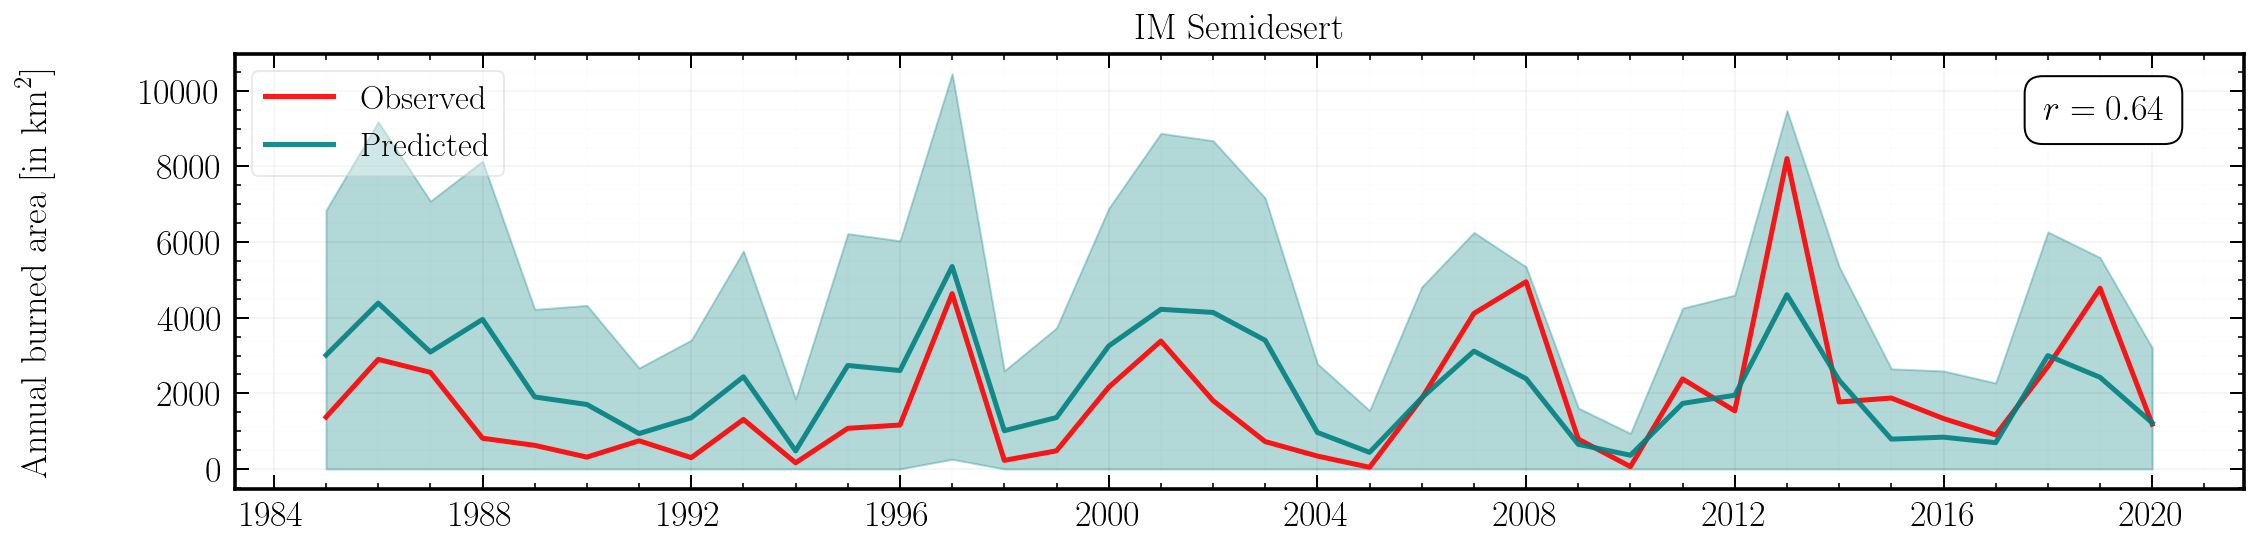

In [66]:
fig, ax= plt.subplots(1, 1, figsize=(18, 4))
fig.text(0.04, 0.5, r'Annual burned area [in ${\rm km}^2$]', va='center', rotation='vertical', fontsize= 18);

plt.plot(yr_arr[1:], obs_sizes, color= 'red', label= 'Observed');
plt.plot(yr_arr[1:], pred_sizes, color= 'teal', label= 'Predicted');
plt.fill_between(yr_arr[1:], pred_high_1sig, pred_low_1sig, color= 'teal', alpha= 0.3)
plt.legend(loc='upper left', frameon= True);
plt.title(r'${\rm IM \ Semidesert}$', fontsize= 18);
ax.set_xticks((year_arr - 1984)*12);
ax.set_xticklabels(year_arr);
ax.text(0.9, 0.85, r'$r = %.2f$'%reg_ann_size_r, fontsize= 18, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax.transAxes)

fig.subplots_adjust(hspace= 0.8)
#fig.minorticks_on()
ax.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
ax.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_ann_fire_size_imsemidesert.pdf', bbox_inches='tight');

### Regional sizes

In [79]:
startmon= 264
totmonths= final_month - startmon
month_arr= np.linspace(startmon, final_month - 1, totmonths, dtype= np.int64)
year_arr= np.asarray([2006, 2009, 2012, 2015, 2018, 2021]) #np.asarray([2015, 2016, 2017, 2018, 2019, 2020])
yr_arr= np.arange(0, tot_months + 1, 12) 

reg_name= {1: "Sierra Nevada", 2: "North Coast", 3: "Central Coast", 4: "South Coast", 5: "Pacific NW", 6: "Columbia Plateau", 7:"Northern Rockies", \
          8: "Middle Rockies", 9: "Southern Rockies", 10: "AM Semidesert", 11: "AZ/NM Mts.", 12: "IM Semidesert", 13: "IM Desert", 14: "Northern Great Plains", \
          15: "High Plains", 16: "CO Plateau", 17: "SW Tablelands", 18: "CH Desert"}
ind_grid_1= [[1, 6], [7, 8]]
ind_grid_2= [[11, 12], [13, 14]]

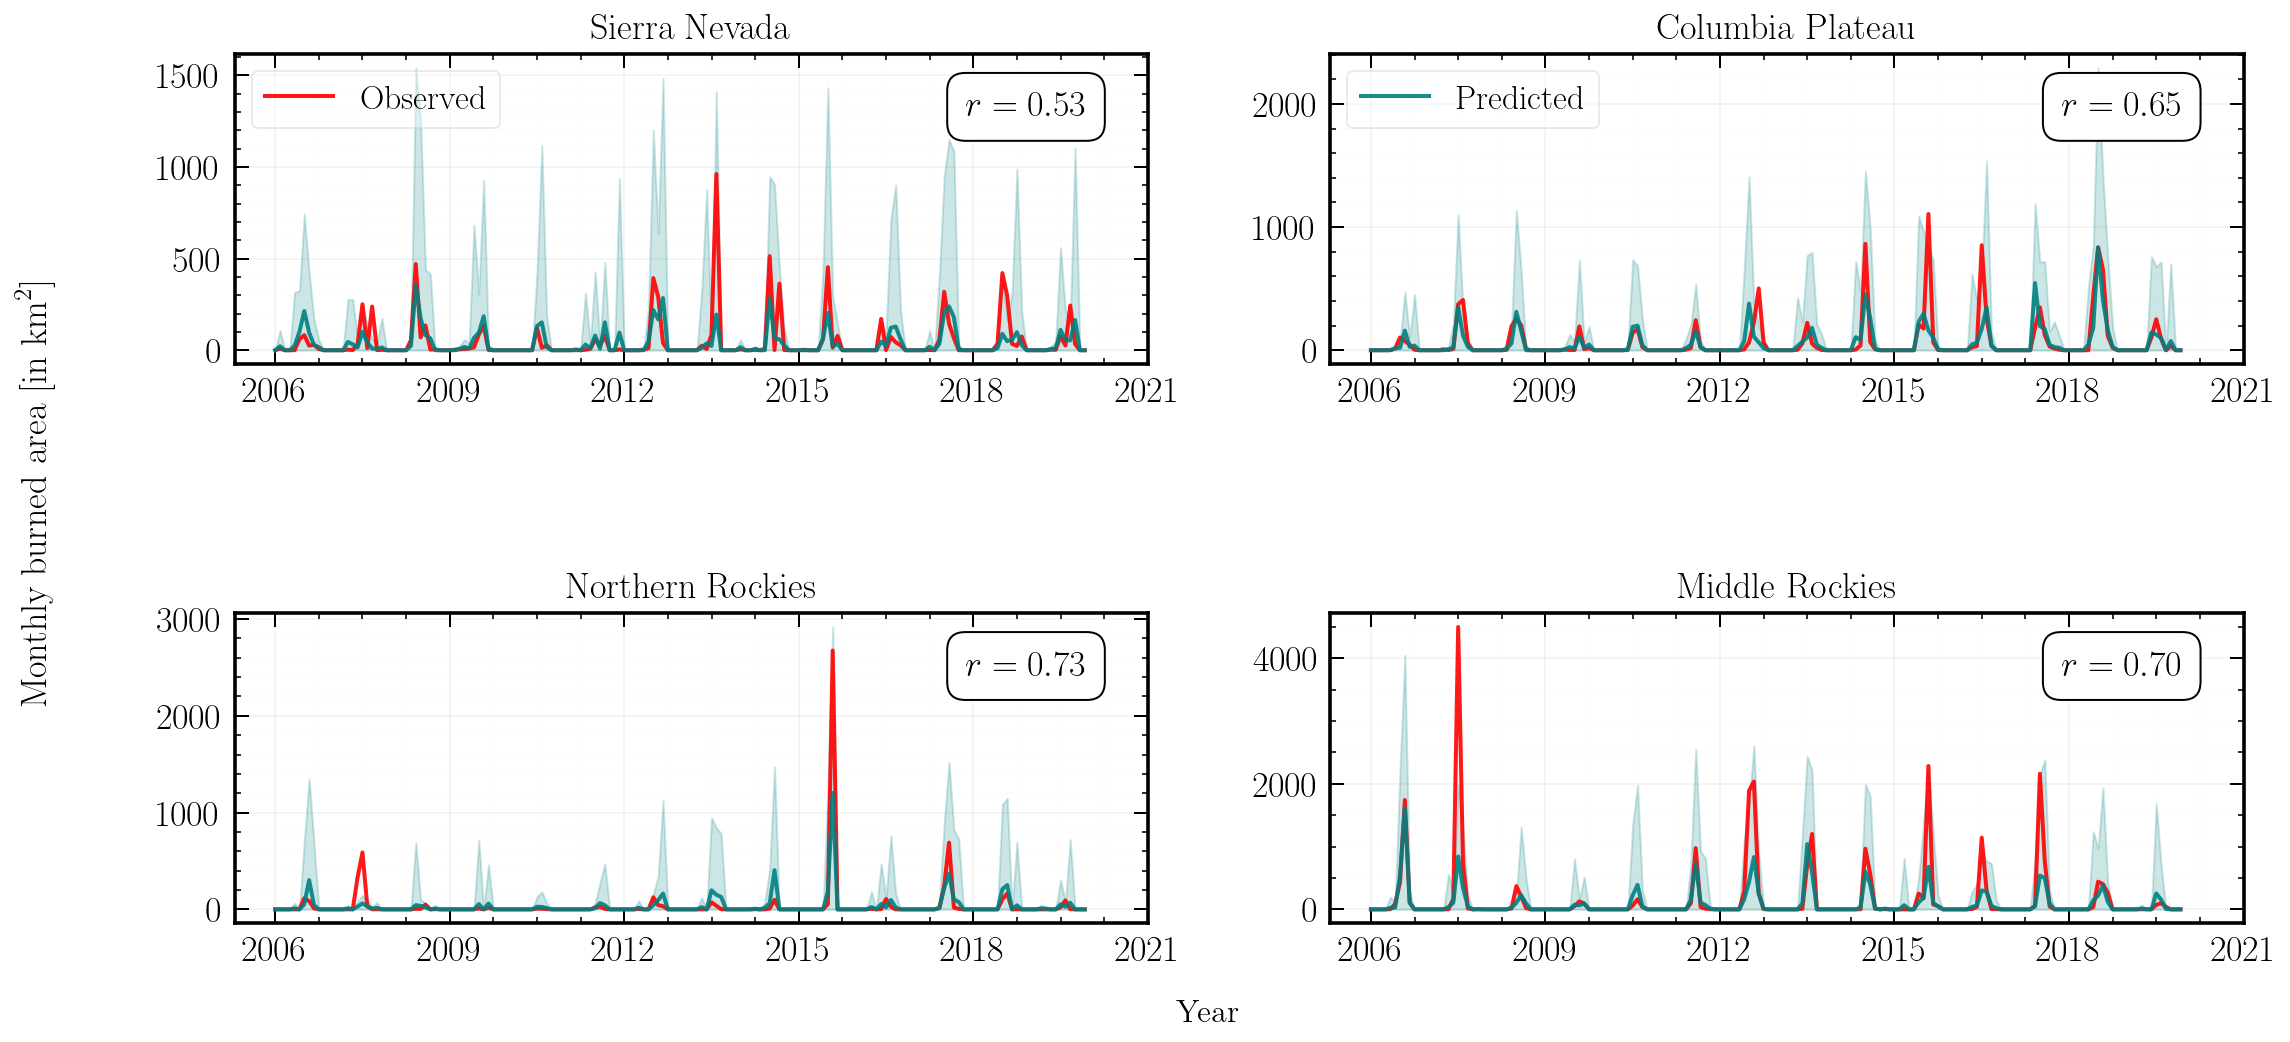

In [89]:
fig, ax= plt.subplots(2, 2, figsize=(18, 8))
#plt.suptitle(r'Monthly fire size', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly burned area [in ${\rm km}^2$]', va='center', rotation='vertical', fontsize= 18);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

for i in range(2):
    for j in range(2):
        regindx= ind_grid_1[i][j]
        reg_mon_r_calib= stats.pearsonr(mon_burned_area(fire_file, regindx), reg_data_size_df.groupby('reg_indx').get_group(regindx)['mean_size'])[0]
        
        if i+j == 0:
            ax[i, j].plot(month_arr, mon_burned_area(fire_file, regindx)[startmon:], color= 'red', lw= 2, label= 'Observed');
            ax[i, j].legend(loc='upper left', frameon= True);
        else:
            ax[i, j].plot(month_arr, mon_burned_area(fire_file, regindx)[startmon:], color= 'red', lw= 2);
        if (i==0)&(j==1):
            ax[i, j].plot(month_arr, reg_data_size_df.groupby('reg_indx').get_group(regindx)['mean_size'][startmon:], color= 'teal', lw= 2, label= 'Predicted');
            ax[i, j].legend(loc='upper left', frameon= True);
        else:
            ax[i, j].plot(month_arr, reg_data_size_df.groupby('reg_indx').get_group(regindx)['mean_size'][startmon:], color= 'teal', lw= 2);
        ax[i, j].fill_between(month_arr, reg_data_size_df.groupby('reg_indx').get_group(regindx)['high_1sig_size'][startmon:], reg_data_size_df.groupby('reg_indx').get_group(regindx)['low_1sig_size'][startmon:], \
                                                                                                                             color= 'teal', alpha=0.2);
        ax[i, j].text(0.8, 0.8, r'$r = %.2f$'%reg_mon_r_calib, fontsize= 18, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[i, j].transAxes)
        ax[i, j].set_title(reg_name[regindx], fontsize= 18);
        ax[i, j].set_xticks((year_arr - 2006)*12 + startmon);
        ax[i, j].set_xticklabels(year_arr)
        #ax[i, j].set_yscale('log')
            
        fig.subplots_adjust(hspace= 0.8)
        #fig.minorticks_on()
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_mon_fire_size_12km_1_data.pdf', bbox_inches='tight');

In [85]:
obssizes_arr= []
predsizes_gpd_arr= []
predsizes_data_arr= []

for r in tqdm(range(n_regions)):
    obssizes_arr.append(mon_burned_area(fire_file, r+1))
    predsizes_gpd_arr.append(reg_ml_gpd_size_df.groupby('reg_indx').get_group(r+1)['mean_size'])
    predsizes_data_arr.append(reg_data_size_df.groupby('reg_indx').get_group(r+1)['mean_size'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.92it/s]


In [86]:
obssizes_arr= np.concatenate(obssizes_arr)
predsizes_gpd_arr= np.concatenate(predsizes_gpd_arr)
predsizes_data_arr= np.concatenate(predsizes_data_arr)
empcdf_obs= tfd.Empirical(obssizes_arr)
empcdf_gpd_pred= tfd.Empirical(predsizes_gpd_arr)
empcdf_data_pred= tfd.Empirical(predsizes_data_arr)

cdf_emp_obs= empcdf_obs.cdf(obssizes_arr)
cdf_emp_gpd_pred= empcdf_gpd_pred.cdf(predsizes_gpd_arr)
cdf_emp_data_pred= empcdf_data_pred.cdf(predsizes_data_arr)
#pvec= mdn_size_model.predict(x= X_sizes_test)
#cdf_mod= gpd_model(pvec).cdf(y_sizes_test).numpy()

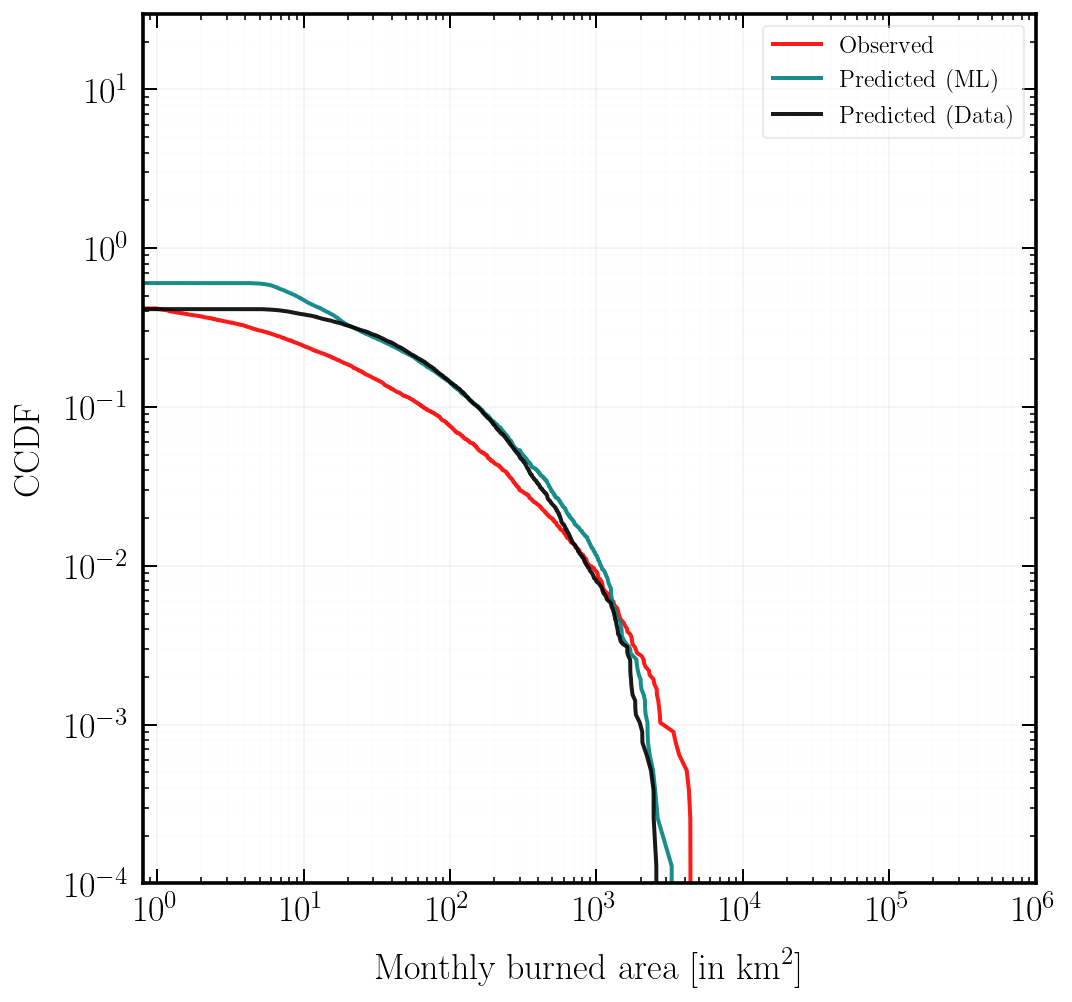

In [87]:
fig, ax= plt.subplots(figsize=(8, 8))

plt.plot(np.sort(obssizes_arr), 1 - np.sort(cdf_emp_obs), color= 'red', lw= 2, label= 'Observed')
plt.plot(np.sort(predsizes_gpd_arr), 1- np.sort(cdf_emp_gpd_pred), color= 'teal', lw= 2, label= 'Predicted (ML)') 
plt.plot(np.sort(predsizes_data_arr), 1- np.sort(cdf_emp_data_pred), color= 'black', lw= 2, label= 'Predicted (Data)') 
#plt.plot(np.sort(y_sizes_test), 1 - np.sort(cdf_mod), label= 'Model')

ax.set_xlabel(r'Monthly burned area [in ${\rm km}^2$]', fontsize= 18);
ax.set_ylabel(r'CCDF', fontsize= 18);

plt.ylim(10**-4, 30);
plt.xlim(0.8, 10**6);
plt.xscale('log')
plt.yscale('log')
plt.minorticks_on();
plt.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 18);
plt.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
plt.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');

plt.legend(loc='upper right', frameon=True, fontsize=12);
#plt.savefig('../plots/grid_fire_size_ccdf.pdf', bbox_inches='tight');

NameError: name 'ind_grid_1' is not defined

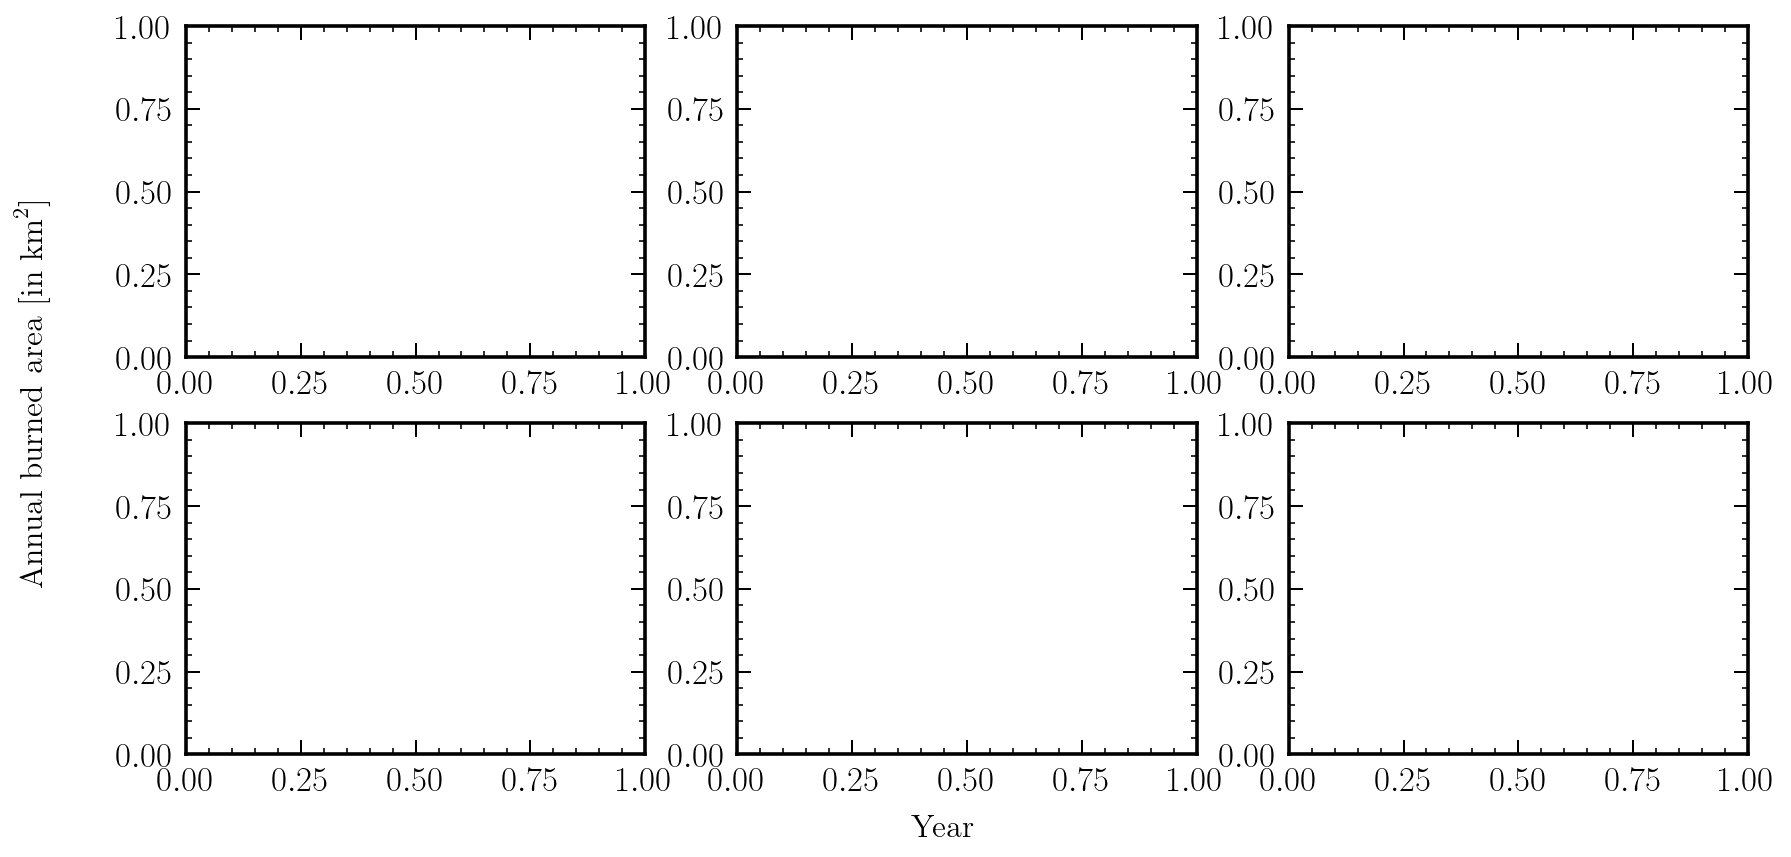

In [6]:
fig, ax= plt.subplots(2, 3, figsize=(14, 6.7))
#plt.suptitle(r'Monthly fire size', fontsize= 18);
fig.text(0.04, 0.5, r'Annual burned area [in ${\rm km}^2$]', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)
#obssizes_arr= []
#predsizes_arr= []

for i in range(2):
    for j in range(3):
        regindx= ind_grid_1[i][j]
        
        obs_sizes= np.array([np.sum(mon_burned_area(fire_file, regindx)[yr_arr[i]:yr_arr[i+1]]).values for i in range(len(yr_arr) - 1)])
        pred_sizes= np.array([np.sum(reg_data_size_df.get_group(regindx)['mean_size'][yr_arr[i]:yr_arr[i+1]]) for i in range(len(yr_arr) - 1)])
        pred_std= np.asarray([np.sqrt(np.sum((((reg_data_size_df.get_group(regindx)['high_1sig_size'] - \
                    reg_data_size_df.get_group(regindx)['low_1sig_size'])/2)**2)[yr_arr[i]:yr_arr[i+1]])) for i in range(len(yr_arr) - 1)])
        pred_high_1sig= pred_sizes + pred_std
        pred_low_1sig= pred_sizes - pred_std
        pred_low_1sig[pred_low_1sig < 0]= 0
        
        if i+j == 0:
            ax[i, j].plot(yr_arr[1:], obs_sizes, lw= 2, label= 'Observed');
            ax[i, j].legend(loc='upper right', frameon= True);
        else:
            ax[i, j].plot(yr_arr[1:], obs_sizes, lw= 2);
        if (i==0)&(j==1):
            ax[i, j].plot(yr_arr[1:], pred_sizes, color= 'orange', lw= 2, label= 'Predicted');
            ax[i, j].legend(loc='upper right', frameon= True);
        else:
            ax[i, j].plot(yr_arr[1:], pred_sizes, color= 'orange', lw= 2);
        ax[i, j].fill_between(yr_arr[1:], pred_high_1sig, pred_low_1sig, color= 'orange', alpha=0.2);
        
        ax[i, j].set_title(reg_name[regindx], fontsize= 14);
        ax[i, j].set_xticks(yr_arr[1:]);
        ax[i, j].set_xticklabels(year_arr[:-1]);
        #ax[i, j].set_yscale('log')
            
        fig.subplots_adjust(hspace= 0.8)
        #fig.minorticks_on()
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_grid_ann_fire_size_1.pdf', bbox_inches='tight');

### Sanity check

In [40]:
tmparr= np.random.choice(np.nonzero(freq_arr[6])[0], (np.sum(freq_arr[6])*(np.std(reg_freq_groups.get_group(1)['obs_freq'])/np.std(pred_freq))).astype(int))

In [41]:
X_test_df.groupby('reg_indx').get_group(1).groupby('month').get_group(m).drop(columns= ['reg_indx', 'month']).index.to_numpy()[tmparr]

array([3746133, 3741808, 3750194, 3741511, 3748828, 3749649, 3742959])

In [13]:
dnn_freq_df= pd.read_hdf('../sav_files/dnn_mon_fire_freq_03_01_22_it_12_8192_0.3.h5')
dnn_freq_groups= dnn_freq_df.groupby('reg_indx')

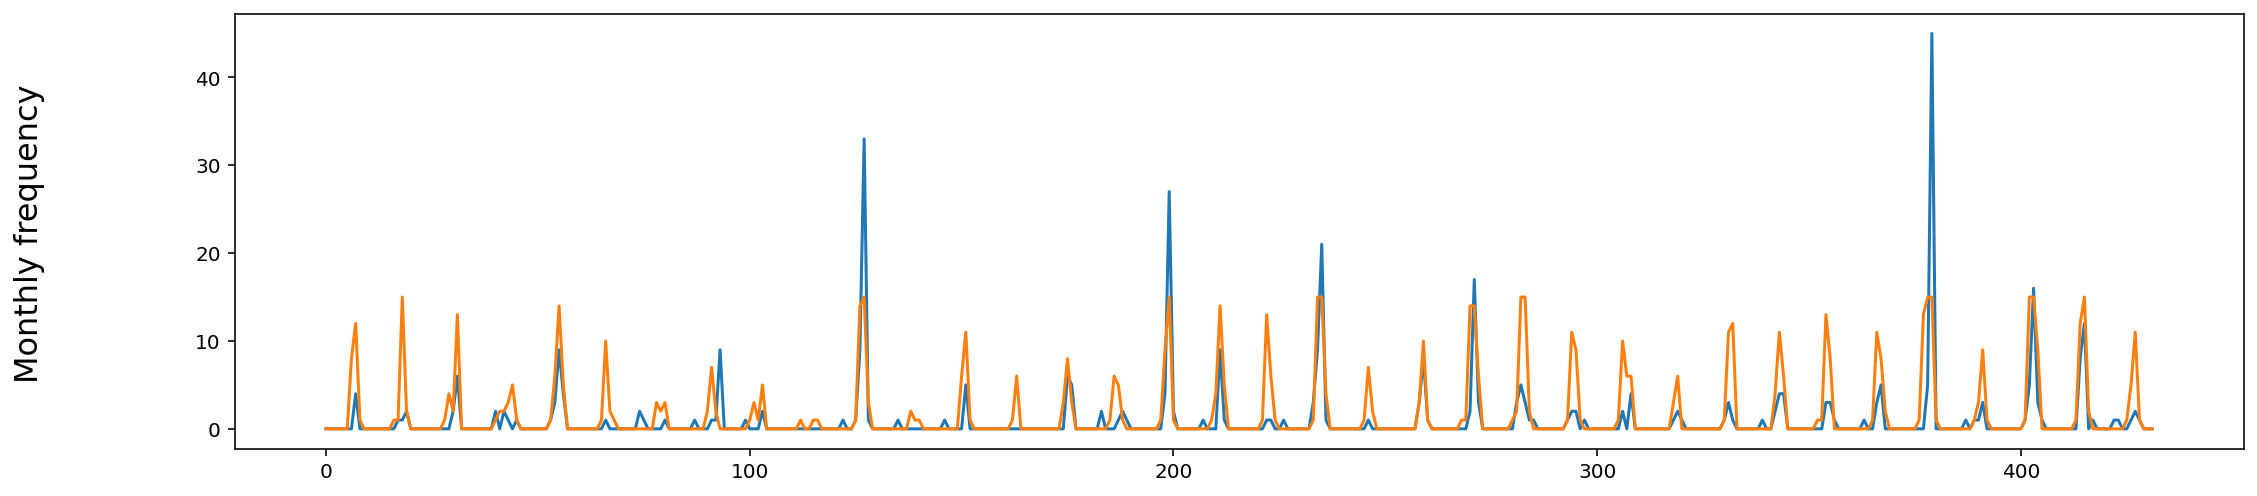

In [24]:
fig, ax= plt.subplots(1, 1, figsize=(18, 4))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly frequency', va='center', rotation='vertical', fontsize= 16);
regindx= 7

plt.plot(month_arr, dnn_freq_groups.get_group(regindx)['obs_freq'])
plt.plot(month_arr, dnn_freq_groups.get_group(regindx)['pred_mean_freq']);
#plt.fill_between(month_arr, mdn_freq_groups.get_group(regindx)['pred_high_2sig'], mdn_freq_groups.get_group(regindx)['pred_low_2sig'], color= 'orange', alpha= 0.3)

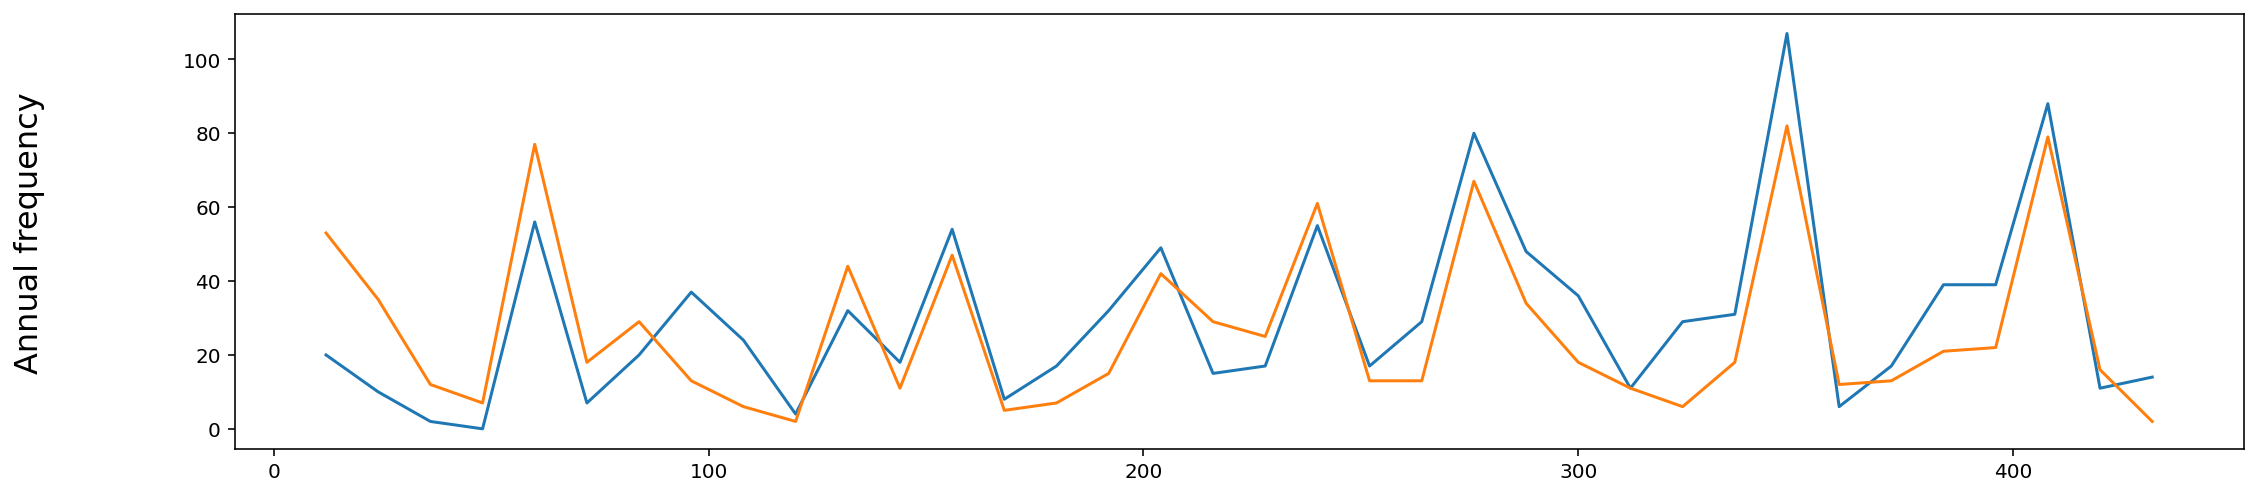

In [23]:
fig, ax= plt.subplots(1, 1, figsize=(18, 4))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Annual frequency', va='center', rotation='vertical', fontsize= 16);
regindx= 14

#pred_std= np.asarray([np.sqrt(np.sum((((mdn_freq_groups.get_group(regindx)['pred_high_2sig'] - \
#                    mdn_freq_groups.get_group(regindx)['pred_low_2sig'])/4)**2)[yr_arr[t]:yr_arr[t+1]])) for t in range(len(yr_arr) - 1)])  
pred_freq= np.array([np.sum(dnn_freq_groups.get_group(regindx)['pred_mean_freq'][yr_arr[t]:yr_arr[t+1]]) for t in range(len(yr_arr) - 1)])

plt.plot(yr_arr[1:], np.array([np.sum(dnn_freq_groups.get_group(regindx)['obs_freq'][yr_arr[t]:yr_arr[t+1]]) for t in range(len(yr_arr) - 1)]));
plt.plot(yr_arr[1:], pred_freq);
#plt.fill_between(yr_arr[1:], pred_freq + 2*pred_std, pred_freq - 2*pred_std, color= 'orange', alpha= 0.3)